In [1]:
import json
import os 
import argparse 
import torch 
import random 
import numpy as np
import pandas as pd 
from tqdm import tqdm 
from collections import defaultdict

from nnsight import LanguageModel
from datasets import load_dataset

import matplotlib.pyplot as plt

/home/zy2559/.conda/envs/attendome/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd() / "src"))

In [3]:
from attendome import attn_utils

In [9]:
pile = load_dataset('JeanKaddour/minipile')['test'] # size=10,000
# pile = load_dataset('JeanKaddour/minipile')['train']

In [10]:
pile[0]['text'].lstrip()

'Stability and proteolytic domains of Nef protein from human immunodeficiency virus (HIV) type 1.\nProteolytic experiments in conjunction with 1H-NMR spectroscopy show that the Nef (negative factor) protein from human immunodeficiency virus type 1 probably consists of two main domains, the N-terminal anchor domain at amino acid positions 2-65 and the C-terminal core domain at positions 66-206. The N-terminal domain is likely to be located at the surface of the protein, while the C-terminal domain has a compactly folded core and is stable in the absence of the anchor domain. It is conceivable that the core domain represents a functional domain of the Nef protein, activated after the removal of the membrane anchor by the human-immunodeficiency-virus protease or cellular proteases. Nef is stable at pH 5-12 and denatures at 317-322 K. The Nef protein remains in its native conformation in dimethyl-sulfoxide/water mixtures up to 35% (by vol.), and in acetonitrile/water up to 14% (by vol.). N

In [ ]:
torch.set_grad_enabled(False)

def generate_ragged_batch(batch_ents, pile, tok, seq_len):
    assert len({len(e) for e in batch_ents}) == 1

    newline = tok('\n', bos=False)[-1]
    bos = tok('', bos=True)[0]

    sequences = []
    start_idxs, end_idxs = [], []
    for ent in batch_ents:
        position = random.choice(range(seq_len // 2, seq_len - len(ent) + 1))
        rand1 = attn_utils.pile_chunk(position, pile, tok)
        rand2 = attn_utils.pile_chunk(seq_len - position - len(ent), pile, tok)

        start_idxs.append(position + 1)
        end_idxs.append(position + len(ent))
        sequences.append(
            [bos] + rand1 + ent + rand2 + [newline] + rand1 
        )

    # since batches have ragged ends by design, save padding offsets 
    flipped_masks = [m - 1 for m in tok(sequences, pad_mask=True)]
    pad_offsets = [-sum(f).item() for f in flipped_masks]

    return sequences, torch.tensor(start_idxs), torch.tensor(end_idxs), torch.tensor(pad_offsets)

def retrieve_attention(model, tokenized, layer, value_weighting=True):
    func = {
        'Qwen/Qwen3-4B' : attn_utils.get_qwen3_attn_weights,
        'meta-llama/Llama-3.2-3B-Instruct' : attn_utils.get_l3_attn_weights,
        'meta-llama/Llama-3.1-8B-Instruct' : attn_utils.get_l3_attn_weights,
        'meta-llama/Meta-Llama-3-8B' : attn_utils.get_l3_attn_weights,
        'meta-llama/Llama-2-7b-hf': attn_utils.get_l2_attn_weights,
        "EleutherAI/gpt-j-6b": attn_utils.get_gptj_attn_weights,
        "EleutherAI/gpt-neox-20b": attn_utils.get_gptneox_attn_weights,
    }[model.config._name_or_path]

    return func(model, tokenized, layer, value_weighting)

def normalize(d, total):
    for k in d.keys():
        d[k] /= total 
    return d 

In [6]:
parser = argparse.ArgumentParser()
parser.add_argument('--model', default='meta-llama/Llama-2-7b-hf')
parser.add_argument('--ckpt', default=None, type=str)
parser.add_argument('--n', default=2048, type=int)
parser.add_argument('--bsz', default=128, type=int, help='may have bugs with bsz=1.')
parser.add_argument('--sequence_len', default=30)
parser.add_argument('--random_tok_entities', action='store_true')
parser.set_defaults(random_tok_entities=False)
args = parser.parse_args("")

In [7]:
random.seed(8)
torch.manual_seed(8)
np.random.seed(8)

# args.model = 'meta-llama/Llama-3.2-3B-Instruct'
# args.model = 'meta-llama/Llama-3.1-8B-Instruct'
# args.model = 'meta-llama/Llama-2-7b-hf'
# args.model = 'meta-llama/Llama-2-13b-hf'
# args.model = 'Qwen/Qwen3-4B'
# args.model = 'EleutherAI/gpt-j-6b'
args.model = "EleutherAI/gpt-neox-20b"
model = LanguageModel(args.model, device_map='audo', attn_implementation='eager')

In [8]:
model_name = args.model.split('/')[-1]
d = model.tokenizer.decode

assert args.bsz <= args.n // 4 

In [9]:
def tok(s, bos=False, model=model, pad_mask=False):
    if pad_mask:
        assert type(s) == list and type(s[0]) == list and type(s[0][0]) == int
        return model.tokenizer.pad({'input_ids' : s}, return_tensors='pt')['attention_mask']

    # otherwise get actual tokens 
    if 'llama' in model.config._name_or_path:
        if not bos: 
            return model.tokenizer(s)['input_ids'][1:]
        else:
            return model.tokenizer(s)['input_ids']
    elif 'qwen' in model.config._name_or_path.lower():
        # qwen models don't have a BOS token, so just return the tokens as-is
        return model.tokenizer(s)['input_ids']
    elif model.config._name_or_path in ['allenai/OLMo-2-1124-7B', 'EleutherAI/pythia-6.9b', 
                                       'EleutherAI/gpt-j-6b', 'EleutherAI/gpt-neox-20b']:
        if not bos:
            return model.tokenizer(s)['input_ids']
        else:
            return [model.tokenizer.bos_token_id] + model.tokenizer(s)['input_ids']

# load in pile sample to use as basic material that we shuffle around 
# pile = load_dataset('NeelNanda/pile-10k')['train']
pile = load_dataset('JeanKaddour/minipile')['test']

In [10]:
model.tokenizer("hello! what's up?")['input_ids'], model.tokenizer("this is crazy")['input_ids']

([25521, 2, 752, 434, 598, 32], [2520, 310, 10412])

In [11]:
model.tokenizer.bos_token_id

0

In [12]:
# dummy entities for comparison 
sorted_entities = defaultdict(list)
if args.random_tok_entities:
    for i in range(args.n):
        doc_toks = []
        while len(doc_toks) < 5:
            doc = pile.shuffle()[0]['text']
            doc_toks = tok(doc)

        random.shuffle(doc_toks)
        if i % 4 == 0: 
            sorted_entities['bigram'].append(doc_toks[:2])
        elif i % 4 == 1: 
            sorted_entities['trigram'].append(doc_toks[:3])
        elif i % 4 == 2:
            sorted_entities['fourgram'].append(doc_toks[:4])
        elif i % 4 == 3: 
            sorted_entities['fivegram'].append(doc_toks[:5])
# load and sort entities of different token lengths
else:
    str_entities = list(pd.read_csv('./data/counterfact_expanded.csv')['subject'])
    for ent in str_entities:
        toks = tok(ent)
        if len(toks) == 2:
            sorted_entities['bigram'].append(toks)
        elif len(toks) == 3: 
            sorted_entities['trigram'].append(toks)
        elif len(toks) == 4: 
            sorted_entities['fourgram'].append(toks)
        elif len(toks) == 5: 
            sorted_entities['fivegram'].append(toks) 

# debug

In [18]:
with model.trace("hello! what's up?"):
    print(model.gpt_neox.layers[5].attention.source)
    # print(model.model.layers[5].self_attn.source)

                            * def forward(
                            0     self,
                            1     hidden_states: torch.FloatTensor,
                            2     attention_mask: torch.FloatTensor,
                            3     head_mask: Optional[torch.FloatTensor] = None,
                            4     layer_past: Optional[Cache] = None,
                            5     output_attentions: Optional[bool] = False,
                            6     cache_position: Optional[torch.LongTensor] = None,
                            7     position_embeddings: Optional[tuple[torch.Tensor, torch.Tensor]] = None,  # necessary, but kept here for BC
                            8     **kwargs: Unpack[FlashAttentionKwargs],
                            9 ):
                           10     input_shape = hidden_states.shape[:-1]
                           11     hidden_shape = (*input_shape, -1, 3 * self.head_size)
                           12 
 self_query_key_value_0 ->

In [21]:
with model.trace("hello! what's up?"):
    # value_states = model.transformer.h[27].attn.source.layer_past_update_0.output[1].save()
    # attn_weights = model.transformer.h[27].attn.source.self__attn_0.output[1].save()
    # value_states = model.model.layers[5].self_attn.source.attention_interface_0.source.repeat_kv_1.output.save()
    value_states = model.gpt_neox.layers[5].attention.source.layer_past_update_0.output[1].save()
    attn_weights = model.gpt_neox.layers[5].attention.source.attention_interface_0.output[1].save()

In [22]:
value_states.shape, attn_weights.shape

(torch.Size([1, 64, 6, 96]), torch.Size([1, 64, 6, 6]))

In [23]:
# get l2 norm of each head value vector [bsz, n_heads, seq_len, n_dims] -> [bsz, n_heads, seq_len]
value_norms = torch.linalg.vector_norm(value_states, dim=-1).detach().cpu()

# attn_weights [bsz, n_heads, seq_len, seq_len]
# attn_weights = attn_weights.softmax(dim=-1).detach().cpu()
attn_weights = attn_weights.detach().cpu()

# then multiply by softmax values and normalize 
effective = attn_weights * value_norms.unsqueeze(2).expand(attn_weights.shape)
effective /= torch.sum(effective, dim=-1, keepdim=True)


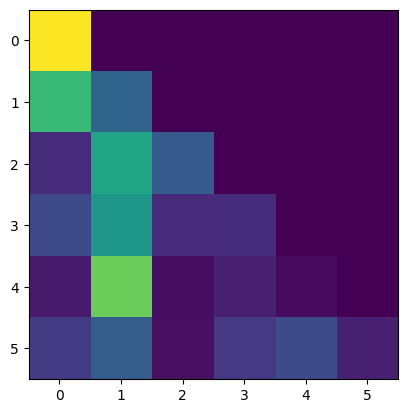

In [30]:
plt.imshow(attn_weights[0,5])

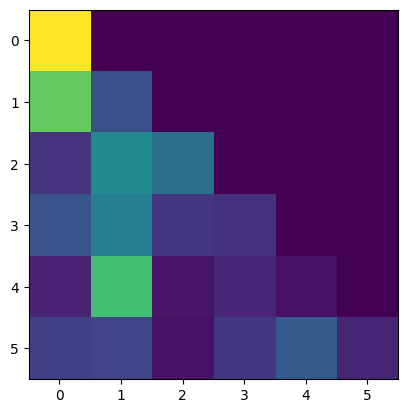

In [29]:
plt.imshow(effective[0,5])

In [28]:
# tokenized = model.tokenizer("hello! what's up?")['input_ids']
# original_effective = attn_utils.get_gptj_attn_weights(model, tokenized, layer=5, value_weighting=True)

In [37]:
(original_effective - effective).sum()

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 

# end debug

In [17]:
# For each head, save the stuff 
total_examples = 0 
next_tok_attn = defaultdict(int)
end_tok_attn = defaultdict(int)

# I guess we're doing each batch is the same length entity 
for l, ents in sorted_entities.items():
    selected_ents = ents[ : args.n // 4]
    n_batches = len(selected_ents) // args.bsz
    print('attention for', l, model.tokenizer.decode(selected_ents[0]))

    for batch_idx in tqdm(range(n_batches)):
        batch_ents = selected_ents[batch_idx * args.bsz : (batch_idx + 1) * args.bsz]
        batch_seqs, start_idxs, end_idxs, pad_offsets = generate_ragged_batch(batch_ents, pile, tok, args.sequence_len)

        print(repr(model.tokenizer.decode(batch_seqs[0])))
        print(start_idxs[0].item(), end_idxs[0].item(), model.tokenizer.decode(batch_seqs[0][start_idxs[0]]), model.tokenizer.decode(batch_seqs[0][end_idxs[0]]))

        # # get attention patterns for each head and example 
        # for layer in range(model.config.num_hidden_layers):
        #     # [bsz, n_heads, seq_from, seq_to]
        #     attns = retrieve_attention(model, batch_seqs, layer)

        #     # index in and save beginnings, ends 
        #     for head in range(model.config.num_attention_heads):
        #         next_tok_attn[(layer, head)] += attns[torch.arange(len(attns)), head, -1, start_idxs + pad_offsets].sum().item()
        #         end_tok_attn[(layer, head)] += attns[torch.arange(len(attns)), head, -1, end_idxs + pad_offsets].sum().item()
        
        # total_examples += len(batch_ents)
        break
    break

attention for fivegram Danielle Darrieux


  0%|          | 0/4 [00:00<?, ?it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (4586 > 2048). Running this sequence through the model will result in indexing errors
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
  0%|          | 0/4 [00:00<?, ?it/s]

'<|endoftext|> = thevar animation Win the object save and anim 1 Step//JS: Create\n resultDanielle Darrieux ChangeVen�ue NASA� For\n = thevar animation Win the object save and anim 1 Step//JS: Create\n result'
19 23 Daniel ux


In [13]:
model_name

'Llama-2-7b-hf'

In [15]:
args.random_tok_entities

False

In [14]:
def json_tuple_keys(mapping):
    return [{'layer':k[0], 'head_idx': k[1], 'score' : v} for k, v in mapping.items()]

results = {
    'next_tok_attn' : json_tuple_keys(normalize(next_tok_attn, total_examples)),
    'end_tok_attn' : json_tuple_keys(normalize(end_tok_attn, total_examples))
}

path = f'./results/attention_scores/{model_name}/'
path += f'{args.ckpt}/' if args.ckpt is not None else ''
os.makedirs(path, exist_ok=True)

fname = f'n{args.n}_seqlen{args.sequence_len}'
fname += f'_randomtokents' if args.random_tok_entities else ''
fname += '.json'
print(path + fname)

with open(path + fname, 'w') as f:
    json.dump(results, f)

./results/attention_scores/Llama-2-7b-hf/n2048_seqlen30.json


In [18]:
for r in results['end_tok_attn']:
    if r['score'] > 0.18:
        print(f"layer: {r['layer']}, head: {r['head_idx']}, score: {r['score']}")

layer: 13, head: 23, score: 0.22054247744381428
layer: 14, head: 1, score: 0.3419952765107155
layer: 16, head: 17, score: 0.22978569567203522
layer: 16, head: 29, score: 0.1967000002041459
layer: 22, head: 17, score: 0.18392631318420172


In [41]:
for r in results['next_tok_attn']:
    if r['score'] > 0.7:
        print(f"layer: {r['layer']}, head: {r['head_idx']}, score: {r['score']}")

layer: 2, head: 16, score: 0.9304505363106728
layer: 2, head: 17, score: 0.8246364444494247
layer: 5, head: 8, score: 0.7392003536224365
layer: 14, head: 22, score: 0.9291573166847229


# analysis

In [58]:
import json
import matplotlib.pyplot as plt
import numpy as np

In [59]:
with open('./results/attention_scores/Qwen3-8B/n2048_seqlen30.json', 'r') as file:
    attention_score = json.load(file)

In [60]:
attention_score.keys()

dict_keys(['next_tok_attn', 'end_tok_attn'])

In [63]:
attention_score['end_tok_attn'][0]

{'layer': 0, 'head_idx': 0, 'score': 0.01287402621505862}

In [52]:
all_induction_scores_new = []
for r in attention_score['next_tok_attn']:
    all_induction_scores_new.append(r['score'])
all_induction_scores_new = np.array(all_induction_scores_new)

In [43]:
with open('./results/induction_heads/induction_dataset_old.json', 'r') as file:
# with open('./data/induction_heads/induction_dataset.json', 'r') as file:
    induction_scores = json.load(file)

In [44]:
induction_scores['metadata']['models']

['allenai/OLMo-2-1124-7B',
 'EleutherAI/pythia-6.9b',
 'Qwen/Qwen3-4B',
 'Qwen/Qwen3-8B',
 'meta-llama/Llama-3.2-3B-Instruct',
 'meta-llama/Llama-3.1-8B-Instruct']

In [53]:
induction_scores['model_results'][3]

{'model_name': 'Qwen/Qwen3-8B',
 'model_configuration': {'num_layers': 36,
  'num_heads': 32,
  'hidden_size': 4096},
 'induction_scores': [[0.008364260196685791,
   0.00021616928279399872,
   0.00020924396812915802,
   0.004987955093383789,
   0.0014980286359786987,
   0.00021565519273281097,
   0.0016570687294006348,
   0.0018634200096130371,
   0.0008199363946914673,
   6.388174369931221e-05,
   0.0025606155395507812,
   0.0026051700115203857,
   0.0030263960361480713,
   0.006565511226654053,
   0.006005346775054932,
   0.0001885034143924713,
   0.0024139732122421265,
   0.0026749372482299805,
   0.00012941984459757805,
   0.001942560076713562,
   0.002452358603477478,
   0.0007272623479366302,
   9.718537330627441e-05,
   0.002460956573486328,
   0.0009596571326255798,
   0.004529625177383423,
   7.318845018744469e-05,
   0.00940239429473877,
   1.5605735825374722e-05,
   0.0015649497509002686,
   0.0025688111782073975,
   0.0025995373725891113],
  [0.007544875144958496,
   0.0125

In [54]:
model_results = induction_scores['model_results'][3]

all_induction_scores_old = []
for layer_id in range(model_results['model_configuration']['num_layers']):
    for head_id in range(model_results['model_configuration']['num_heads']):
        score = model_results['induction_scores'][layer_id][head_id]
        all_induction_scores_old.append(score)
        if score > 0.5:
            print(layer_id, head_id, score)
all_induction_scores_old = np.array(all_induction_scores_old)

2 31 0.8259124755859375
4 4 0.6185989379882812
7 23 0.6594924926757812
13 13 0.9833526611328125
13 14 0.7524642944335938
13 15 0.7727508544921875
13 28 0.5546798706054688
20 21 0.862213134765625
20 26 0.7721939086914062
22 22 0.7737884521484375
22 23 0.9665603637695312
23 4 0.6193313598632812
24 22 0.9049224853515625
24 23 0.6683578491210938
29 9 0.8281097412109375
29 11 0.8889312744140625
33 29 0.6283340454101562


In [55]:
all_induction_scores_old.shape, all_induction_scores_new.shape

((1152,), (1152,))

In [56]:
np.isnan(all_induction_scores_new.sum())

np.False_

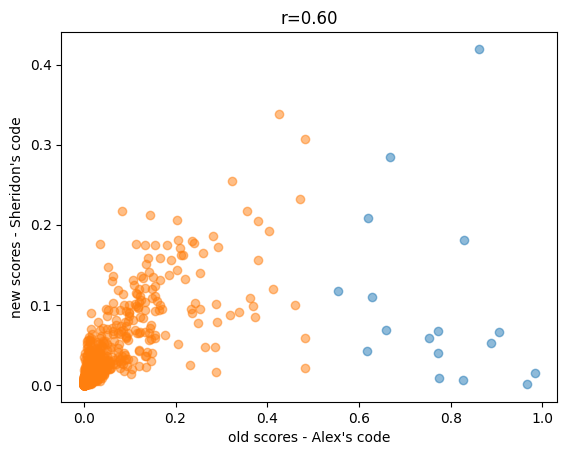

In [57]:
from scipy.stats import pearsonr
r, _ = pearsonr(all_induction_scores_old, all_induction_scores_new)

import matplotlib.pyplot as plt
mask = all_induction_scores_old>0.5
plt.scatter(all_induction_scores_old[mask], all_induction_scores_new[mask], alpha=0.5)
plt.scatter(all_induction_scores_old[~mask], all_induction_scores_new[~mask], alpha=0.5)
plt.xlabel("old scores - Alex's code")
plt.ylabel("new scores - Sheridon's code")
plt.title(f"r={r:.2f}")
plt.show()